<a href="https://colab.research.google.com/github/tanvirlongia/Drinking_Water_Quality/blob/main/Water_Quality_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Load the data
url = 'https://drive.google.com/file/d/1-yTmAm1Gry7zokub-CdDqvRKVEMqdd9R/view?usp=sharing'

path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

prem_data = pd.read_csv(path, low_memory=False)
data = pd.read_csv(path, low_memory=False)
prem_data
#prem_data = pd.read_csv('Drinking_Water_Quality_Distribution_Monitoring_Data_20241127.csv')
#prem_data

,Sample Number,Sample Date,Sample Time,Sample Site,Sample class,Residual Free Chlorine (mg/L),Turbidity (NTU),Fluoride (mg/L),Coliform (Quanti-Tray) (MPN /100mL),E.coli(Quanti-Tray) (MPN/100mL)
0,201655703,08/09/2016,10:31,43250,Compliance,0.68,0.74,NaN,<1,<1
1,201655704,08/09/2016,11:27,46850,Compliance,0.81,1.45,NaN,<1,<1
2,201655705,08/09/2016,10:14,50200,Operational,0.79,0.74,NaN,<1,<1
3,201655706,08/09/2016,12:12,50300,Operational,0.92,0.63,NaN,<1,<1
4,201655707,08/09/2016,10:17,76550,Compliance,0.06,0.6,NaN,<1,<1
...,...,...,...,...,...,...,...,...,...,...
148887,202425988,09/30/2024,1899-12-31T11:13:00.000,50200,Operational,0.94,0.58,NaN,<1,<1
148888,202425989,09/30/2024,1899-12-31T10:46:00.000,50300,Operational,0.98,0.62,NaN,<1,<1
148889,202425990,09/30/2024,1899-12-31T09:56:00.000,51050,Compliance,0.61,0.47,NaN,<1,<1
148890,202425991,09/30/2024,1899-12-31T09:12:00.000,58350,Compliance,0.68,0.48,NaN,<1,<1


In [ ]:
sample_class_counts = prem_data['Sample class'].value_counts()
print(sample_class_counts)

Sample class
Compliance              92621
Operational             55464
Resample_Compliance       709
Op-resample                55
Resample_Operational       43
Name: count, dtype: int64


In [ ]:
# Pre Processing

# Drop unnecessary columns
prem_data = prem_data.dropna()
prem_data.reset_index(drop=True, inplace=True)
data = prem_data
data = data.drop(['Sample Time','Sample Site','Sample class','Sample Date', 'Sample Number'],axis=1)

# Had to fix some values as some had a strange notation and everything was stored as string
Ecoli = 'E.coli(Quanti-Tray) (MPN/100mL)'
Cloriform = 'Coliform (Quanti-Tray) (MPN /100mL)'
Turbunity = 'Turbidity (NTU)'
Free_Chlorine = 'Residual Free Chlorine (mg/L)'
Floride = 'Fluoride (mg/L)'
data[Ecoli] = data[Ecoli].replace('<1', 0).astype(float)
data[Cloriform] = data[Cloriform].replace('<1', 0)
data[Cloriform] = data[Cloriform].replace('>200.5',201).astype(float)
data[Turbunity] = data[Turbunity].replace('<10.5',10)
data[Turbunity] = data[Turbunity].replace('<0.10',0.1).astype(float)
data[Free_Chlorine] = data[Free_Chlorine].astype(float)
data[Floride] = data[Floride].replace('<0.3',0.3)
data[Floride] = data[Floride].replace('<0.30',0.3).astype(float)

# Normalizer
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% variance
reduced_data = pca.fit_transform(scaled_data)

reduced_data




array([[-0.40976519, -2.95969059, -6.60374603,  1.65775472, -0.2301934 ],
       [-0.64385168, -4.8775567 , -8.8302273 ,  3.22844455, -0.53342099],
       [-0.52453839, -3.71912785, -6.94727649,  1.73540412, -0.26079921],
       ...,
       [-0.26881848, -1.08261701,  0.33858527, -1.878286  ,  0.3032678 ],
       [-0.44816717, -2.41391917, -1.25230958, -1.23397495,  0.18211022],
       [-0.40074566, -2.09127756, -0.32829012, -1.25019242,  0.1661709 ]])

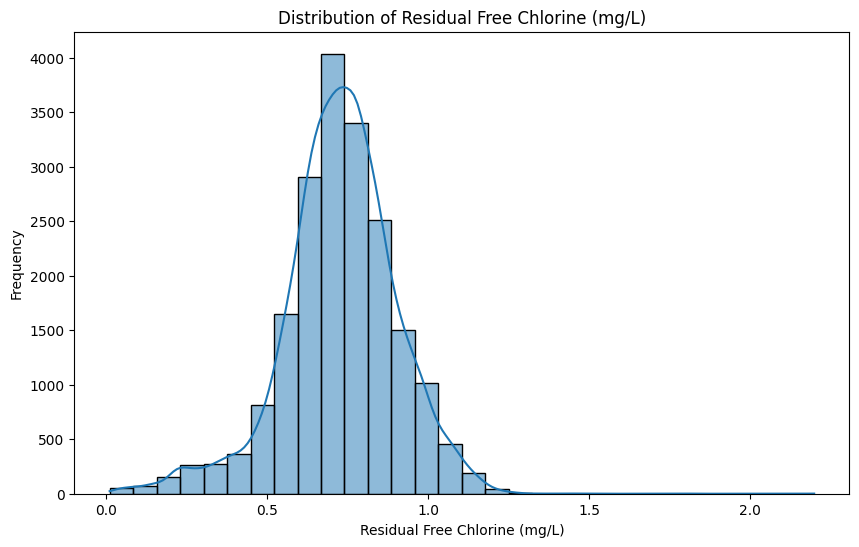

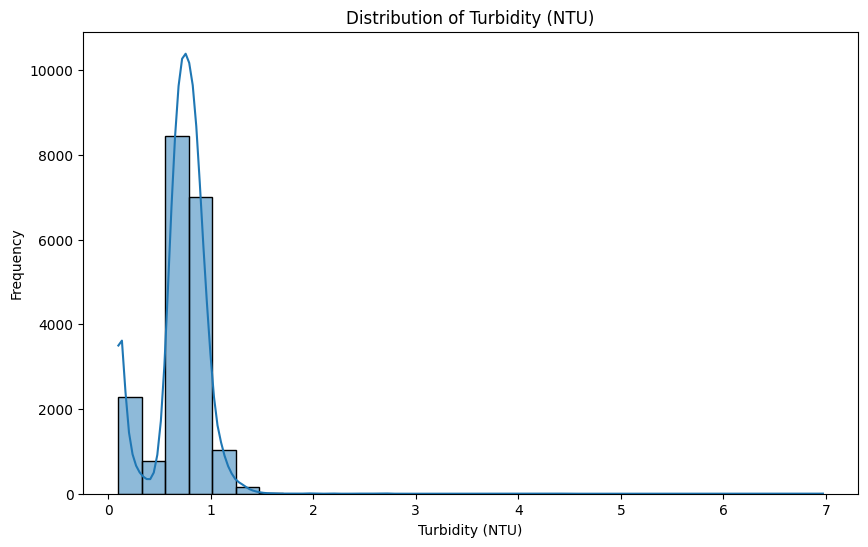

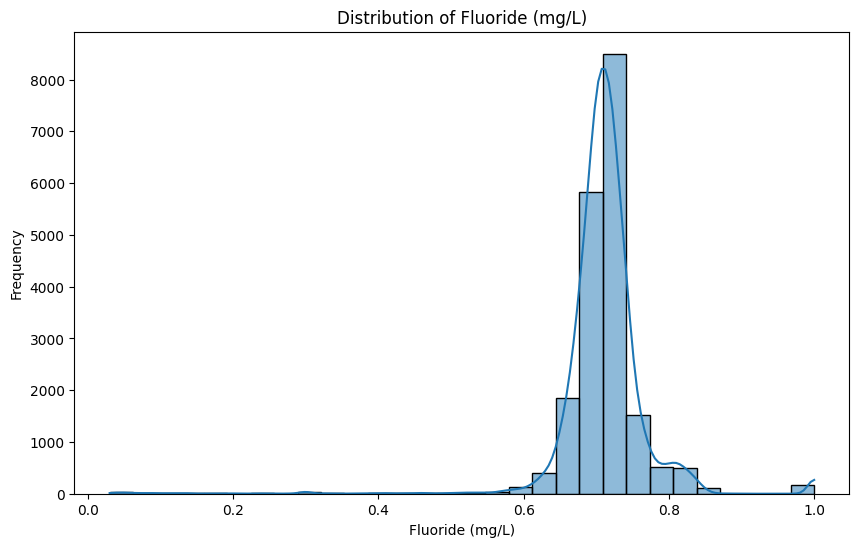

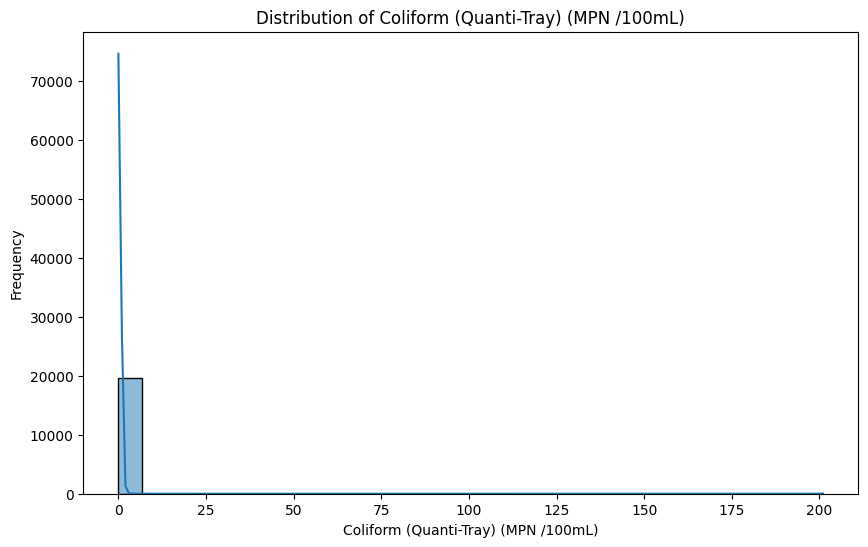

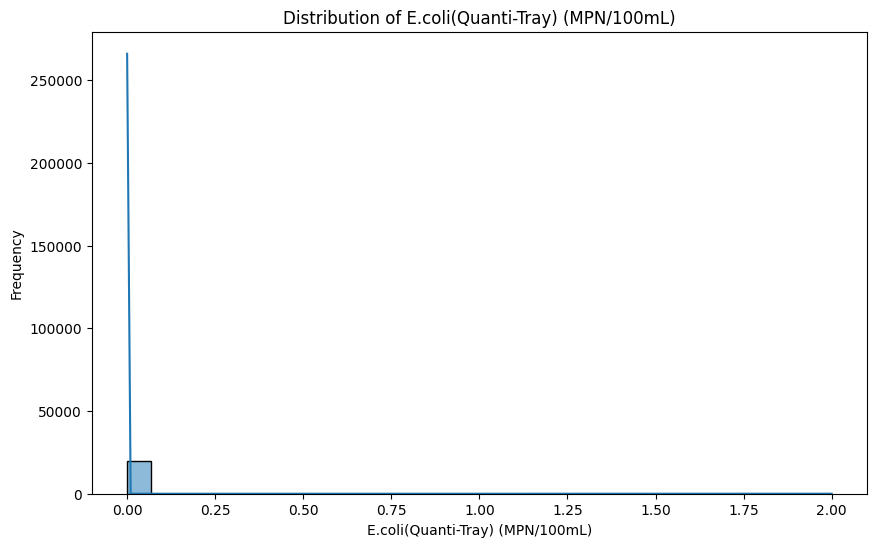

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of columns to exclude
exclude_columns = ['Sample Number', 'Sample Date', 'Sample Time', 'Sample Site', 'Anomaly_Score',	'Is_Anomaly']

# Loop through all columns except those in exclude_columns and create distribution plots
for column in data.columns:
    if column not in exclude_columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[column], kde=True, bins=30)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

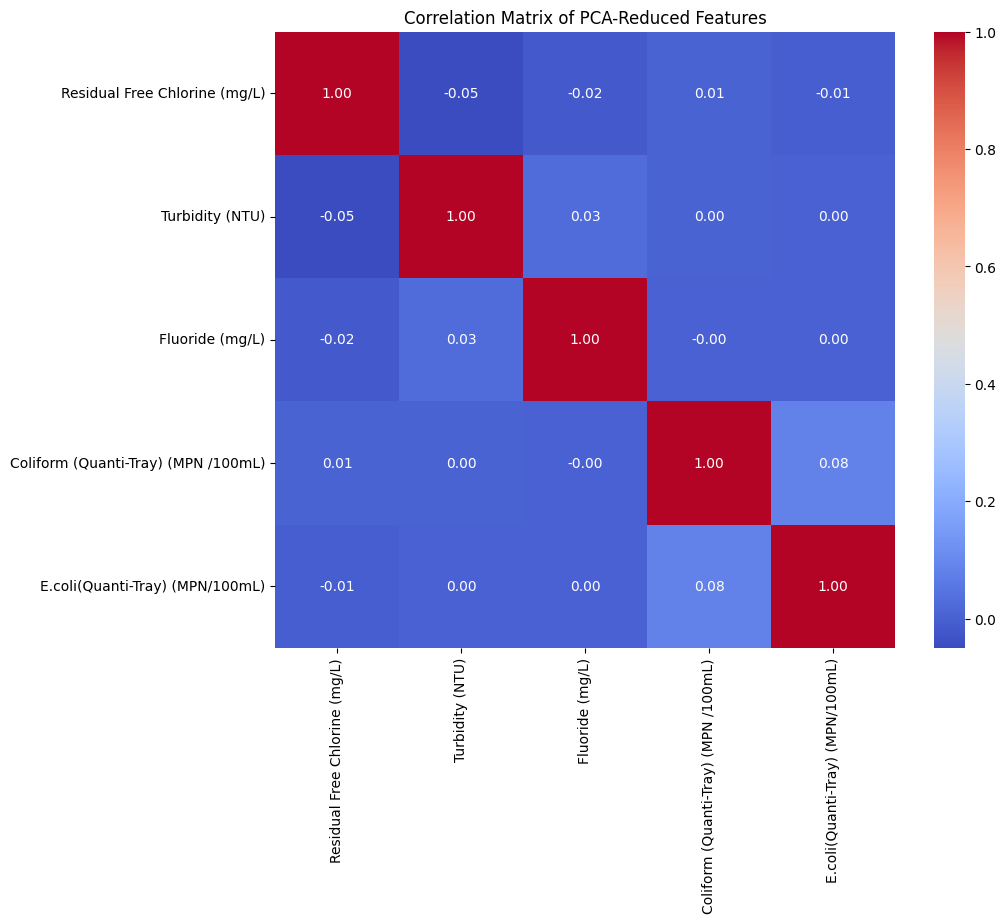

In [ ]:



correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of PCA-Reduced Features")
plt.show()

<ipython-input-35-02eece6fb9d7>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  other_data['Sample class'] = other_data['Sample class'].replace(i,count)


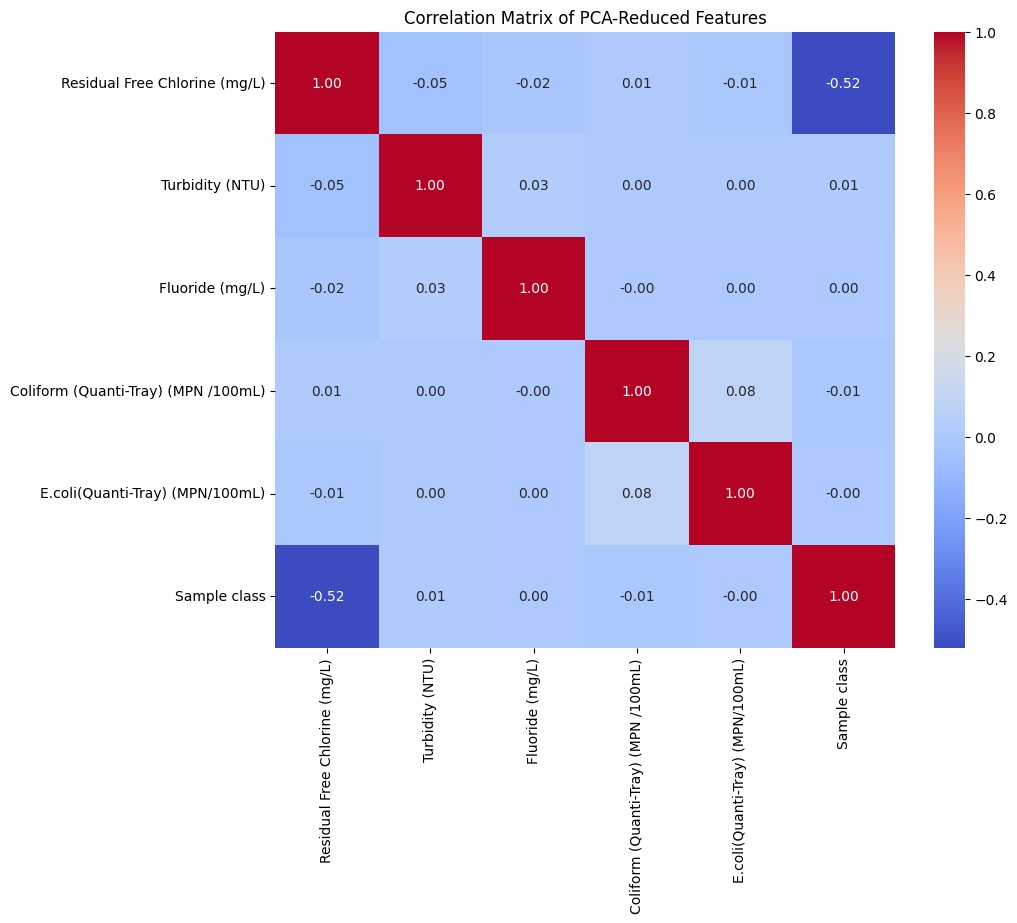

In [ ]:

other_data = data
other_data['Sample class'] = prem_data['Sample class']
count = 1
for i in other_data['Sample class'].unique():
  other_data['Sample class'] = other_data['Sample class'].replace(i,count)
  count+=1

correlation_matrix = other_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of PCA-Reduced Features")
plt.show()

In [ ]:
#KNN cluster anomily

knn = NearestNeighbors(n_neighbors=5)
knn.fit(reduced_data)
distances, _ = knn.kneighbors(reduced_data)
anomaly_scores = distances.mean(axis=1)
prem_data['Anomaly_Score'] = anomaly_scores
data = prem_data
threshold = data['Anomaly_Score'].quantile(0.99)
data['Is_Anomaly'] = data['Anomaly_Score'] > threshold
num_anomalies = data['Is_Anomaly'].sum()
print(f"Number of anomalies: {num_anomalies}")

results = data[data['Is_Anomaly']]['Sample class'].value_counts()

data[data['Is_Anomaly']].head()


Number of anomalies: 198


<ipython-input-36-0d3f0ada3347>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prem_data['Anomaly_Score'] = anomaly_scores
<ipython-input-36-0d3f0ada3347>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Is_Anomaly'] = data['Anomaly_Score'] > threshold


,Sample Number,Sample Date,Sample Time,Sample Site,Sample class,Residual Free Chlorine (mg/L),Turbidity (NTU),Fluoride (mg/L),Coliform (Quanti-Tray) (MPN /100mL),E.coli(Quanti-Tray) (MPN/100mL),Anomaly_Score,Is_Anomaly
1,201655798,08/10/2016,11:09,1S03A,Operational,1.01,0.91,0.06,<1,<1,0.547890,True
2,201655799,08/10/2016,11:45,1S03B,Operational,0.84,0.73,0.21,<1,<1,0.427750,True
5,201655802,08/10/2016,10:37,52050,Compliance,0.61,2.53,0.61,<1,<1,1.560791,True
8,202120279,07/01/2021,09:17,1S03B,Operational,0.72,0.76,0.72,11.1,<1,0.904950,True
140,202122743,07/23/2021,10:36,1SCH3,Operational,0.67,0.67,0.72,>200.5,<1,0.696630,True


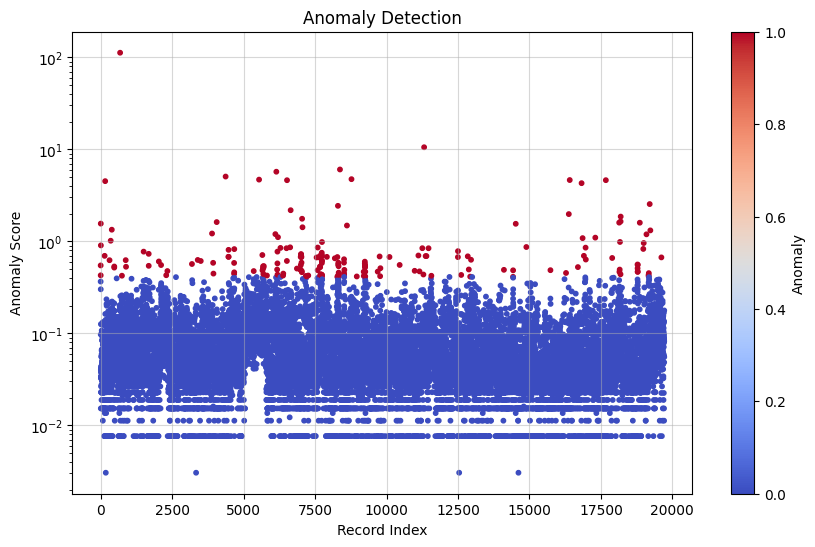

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(data)), data['Anomaly_Score'], c=data['Is_Anomaly'], cmap='coolwarm', s=10)
plt.colorbar(label='Anomaly')
plt.title('Anomaly Detection')
plt.xlabel('Record Index')
plt.ylabel('Anomaly Score')
plt.yscale('log')
plt.grid(alpha=0.5)
plt.show()


In [ ]:


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    reduced_data, prem_data['Sample class'], test_size=0.2, random_state=42
)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

# Compare models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy

# Print results
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy:.2f}")

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Logistic Regression: Accuracy = 0.93
Decision Tree: Accuracy = 0.90
Random Forest: Accuracy = 0.93
KNN: Accuracy = 0.94
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 17, 'weights': 'uniform'}
Best Accuracy: 0.9444023487393565


In [ ]:
# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Stratified CV to handle imbalanced classes
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and hyperparameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance']}
    }
}

# Perform hyperparameter tuning and cross-validation
best_models = {}
for name, model_info in models.items():
    model = model_info['model']
    params = model_info['params']

    grid_search = GridSearchCV(
        model,
        params,
        cv=stratified_cv,
        scoring='f1_weighted',  # Use multiclass-compatible scoring
        n_jobs=-1,
        error_score='raise'
    )

    # Fit the model using GridSearch
    grid_search.fit(X_train, y_train_encoded)
    best_models[name] = grid_search.best_estimator_

    print(f"{name} Best Params: {grid_search.best_params_}")
    print(f"{name} Best Cross-Validated F1 Score: {grid_search.best_score_:.4f}")


Logistic Regression Best Params: {'C': 1, 'solver': 'liblinear'}
Logistic Regression Best Cross-Validated F1 Score: 0.9333
Random Forest Best Params: {'max_depth': 10, 'n_estimators': 50}
Random Forest Best Cross-Validated F1 Score: 0.9384
KNN Best Params: {'n_neighbors': 14, 'weights': 'uniform'}
KNN Best Cross-Validated F1 Score: 0.9395
